<a href="https://colab.research.google.com/github/azhgh22/ML04_Facial_Expression_Recognition_Challenge/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip
! rm challenges-in-representation-learning-facial-expression-recognition-challenge.zip
! rm fer2013.tar.gz
! rm icml_face_data.csv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 57.0 MB/s eta 0:00:00
Mounted at /content/drive
 86% 246M/285M [00:00<00:00, 725MB/s] 
100% 285M/285M [00:00<00:00, 778MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


**Imports**

In [2]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


## **Slit data into Train(70%), Validation(15%), Test(15%)**

In [3]:
data = pd.read_csv("train.csv")

In [ ]:
data.head(10)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...
9,2,255 254 255 254 254 179 122 107 95 124 149 150...


In [4]:
train=data.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%

In [ ]:
train['emotion'].value_counts()

,count
emotion,
3,5035
6,3479
4,3402
2,2883
0,2811
5,2187
1,299


## **Custom DataSet class and Transformer**

In [ ]:
train['emotion']

,emotion
14538,3
25662,2
413,5
917,6
7130,3
...,...
14779,1
13190,0
16056,4
8977,4


In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(np.array(dataframe['emotion'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        pixels = [int(x) for x in self.dataframe.iloc[idx, 1].split()]
        label = self.labels[idx]

        image = Image.fromarray(np.array(pixels,dtype=np.uint8).reshape(48, 48))

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)

In [7]:
small_dataset = CustomImageDataset(dataframe=train.sample(n=20,random_state=7),transform=transform)
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

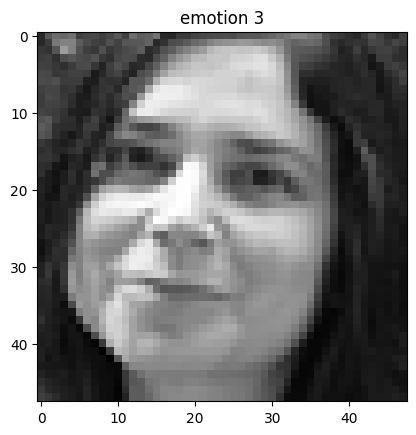

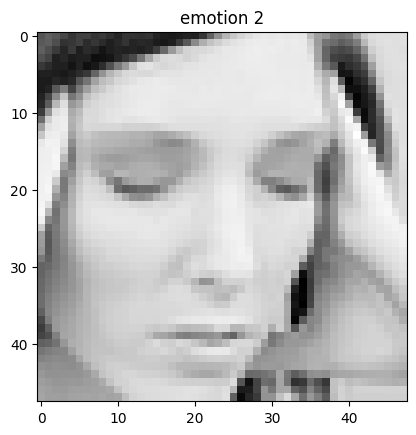

In [8]:
for i in range(2):
  img, label = train_dataset[i]

  plt.imshow(img.squeeze().cpu().numpy(),cmap='gray')
  plt.title(f"emotion {label}")
  plt.show()

## **Hyperparameters**

In [9]:
LR = 1e-4
BATCH_SIZE = 128
EPOCHS = 10
N_CLASSES = 7

# **Dataloaders**

In [10]:
small_loader = DataLoader(small_dataset,batch_size=20,shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## **Model**

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1,32,kernel_size=3,padding=1,stride=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32,64,kernel_size=3,padding=1,stride=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(24*24*64,N_CLASSES),
    # nn.ReLU(),
    # nn.Linear(128,N_CLASSES)
).cuda()

## **Model Summary**

In [ ]:
from torchsummary import summary
summary(model, input_size = (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 48, 48]          18,496
              ReLU-5           [-1, 64, 48, 48]               0
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         MaxPool2d-7           [-1, 64, 24, 24]               0
           Flatten-8                [-1, 36864]               0
            Linear-9                    [-1, 7]         258,055
Total params: 277,063
Trainable params: 277,063
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 5.63
Params size (MB): 1.06
Estimated Total Size (MB): 6.69
-------------------------------------------

## **Training**

In [11]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [12]:
def train(model, optimizer, train_data_loader ,epochs=1,val_data_loader = None,criterion = nn.CrossEntropyLoss()):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    train_epoch_evol_loss = []
    train_epoch_evol_acc = []

    val_epoch_evol_loss = []
    val_epoch_evol_acc = []

    current_loss = 0
    i = 0
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_data_loader):
            model.train()  # put model to training mode
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            loss = criterion(scores, y)
            current_loss = loss.item()
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()


        print('epoch %d, loss = %.4f' % (i, loss.item()))
        print()
        i+=1
        train_accuracy = check_accuracy(train_data_loader, model)
        train_epoch_evol_loss.append(current_loss)
        if val_data_loader is not None:
          val_accuracy = check_accuracy(val_data_loader, model)
          train_epoch_evol_acc.append(train_accuracy)
          val_epoch_evol_acc.append(val_accuracy)

    return val_epoch_evol_acc, train_epoch_evol_acc, train_epoch_evol_loss

In [38]:
# model = nn.Sequential(
#     nn.Conv2d(1,32,kernel_size=3,padding=1,stride=1),
#     nn.ReLU(),
#     nn.BatchNorm2d(32),
#     nn.Conv2d(32,64,kernel_size=3,padding=1,stride=1),
#     nn.ReLU(),
#     nn.BatchNorm2d(64),
#     nn.MaxPool2d(kernel_size=2,stride=2),
#     nn.Flatten(),
#     nn.Linear(24*24*64,128),
#     nn.ReLU(),
#     nn.Linear(128,N_CLASSES)
# ).cuda()

model = nn.Sequential(
    nn.Conv2d(1,1,kernel_size=3,padding=1,stride=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.BatchNorm1d(48*48*1),
    nn.Linear(48*48*1,N_CLASSES)
).cuda()

Adam
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)
val_epoch_evol_acc, train_epoch_evol_acc, train_epoch_evol_loss = train(model,Adam(model.parameters(), lr=0.001),train_loader,10,val_loader)
# val_epoch_evol_acc, train_epoch_evol_acc, train_epoch_evol_loss = train(model,optimizer,small_loader,15,None)
# best_lr = 99999999
# best_loss = 99999999
# for i in range(30):
#   print("##################\n")
#   print(i)
#   lr = 10 ** np.random.uniform(-8,-1)
#   val_epoch_evol_acc, train_epoch_evol_acc, train_epoch_evol_loss = train(model,Adam(model.parameters(), lr=lr),small_loader,10,None)
#   if train_epoch_evol_loss[-1] < best_loss:
#     best_lr = lr
#     best_loss = train_epoch_evol_loss[-1]
#   print("##################\n")
# print(f"Best is {lr} with {best_loss}")

epoch 0, loss = 1.8016

Got 5046 / 20096 correct (25.11)
Got 1060 / 4306 correct (24.62)
epoch 1, loss = 1.7810

Got 5092 / 20096 correct (25.34)
Got 1060 / 4306 correct (24.62)
epoch 2, loss = 1.8080

Got 5225 / 20096 correct (26.00)
Got 1059 / 4306 correct (24.59)
epoch 3, loss = 1.8034

Got 5351 / 20096 correct (26.63)
Got 1053 / 4306 correct (24.45)
epoch 4, loss = 1.7476

Got 5543 / 20096 correct (27.58)
Got 1045 / 4306 correct (24.27)
epoch 5, loss = 1.7936

Got 5735 / 20096 correct (28.54)
Got 1038 / 4306 correct (24.11)
epoch 6, loss = 1.7515

Got 5958 / 20096 correct (29.65)
Got 1018 / 4306 correct (23.64)
epoch 7, loss = 1.8115

Got 6090 / 20096 correct (30.30)
Got 1021 / 4306 correct (23.71)
epoch 8, loss = 1.7331

Got 6260 / 20096 correct (31.15)
Got 1023 / 4306 correct (23.76)
epoch 9, loss = 1.6906

Got 6275 / 20096 correct (31.23)
Got 1026 / 4306 correct (23.83)


## **Plot Estimators**

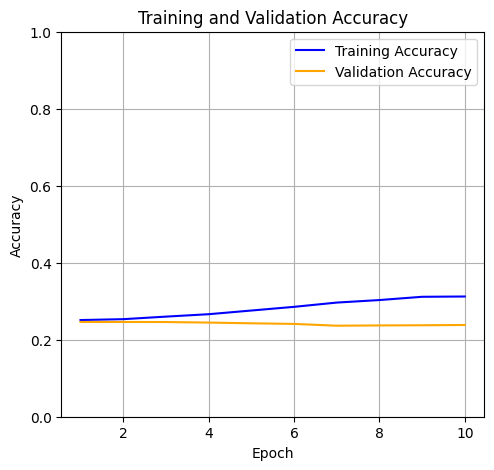

In [40]:
epochs_range = range(1, 10 + 1) # x-axis for epochs, starting from 1
plt.figure(figsize=(12, 5)) # Create a figure with a good size

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(epochs_range, train_epoch_evol_acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_epoch_evol_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 1) # Accuracy typically ranges from 0 to 1

plt.savefig("val_train_accuracy.png")

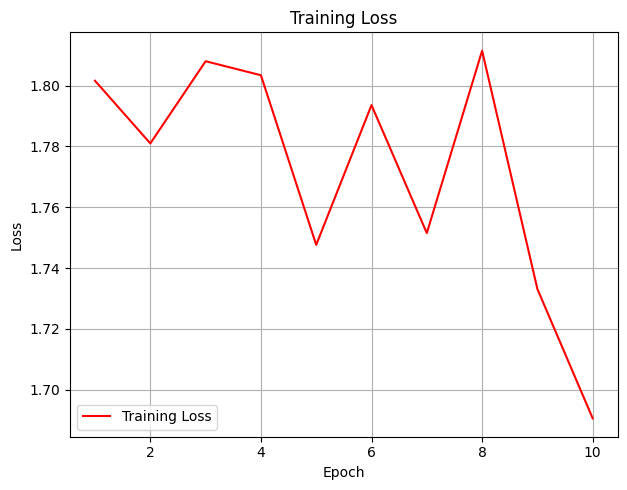

<Figure size 640x480 with 0 Axes>

In [41]:
# plot train loss
plt.figure(figsize=(12, 5)) # Create a figure with a good size

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(epochs_range, train_epoch_evol_loss, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plot
plt.savefig("train_loss.png")

## **Testing**

## **Log to Wandb**

In [ ]:
! pip install wandb

In [ ]:
! wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: azhgh22 (azhgh22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import random
import wandb

LR = 1e-4
BATCH_SIZE = 256
EPOCHS = 10
N_CLASSES = 7

config = {
    "learning_rate": LR,
    "batch_size" : BATCH_SIZE,
    "epochs" : EPOCHS,
    "architecture": "CNN",
    "optimizer" : "Adam",
    "loss function" : "Cross-entropy loss",
    "architecture" : "run4",
    "batchnorm" : "yes",
    "drop out" : 0.6,
    "weight_decay" : 10**-4
}

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="azhgh22-free-university-of-tbilisi-",
    # Set the wandb project where this run will be logged.
    project="Face recognition",
    # Track hyperparameters and run metadata.
    config=config,
    name=config["architecture"]
)

model = nn.Sequential(
    nn.Conv2d(1,32,kernel_size=3,padding=1,stride=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout(config['drop out']),
    nn.Conv2d(32,64,kernel_size=3,padding=1,stride=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(24*24*64,128),
    nn.ReLU(),
    nn.Dropout(config['drop out']),
    nn.Linear(128,N_CLASSES)
).cuda()

optimizer = Adam(model.parameters(), lr=LR,weight_decay=config['weight_decay'])
criterion = nn.CrossEntropyLoss()
val_epoch_evol_acc, train_epoch_evol_acc, train_epoch_evol_loss = train(model,optimizer,train_loader,EPOCHS,val_loader,criterion)


for i in range(1,EPOCHS+1):
  run.log({"train_acc": train_epoch_evol_acc[i-1]},step=i)
  run.log({"validation_acc": val_epoch_evol_acc[i-1]},step=i)
  run.log({"train_loss" : train_epoch_evol_loss[i-1]},step=i)

epochs_range = range(1, 15 + 1) # x-axis for epochs, starting from 1
plt.figure(figsize=(12, 5)) # Create a figure with a good size

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(epochs_range, train_epoch_evol_acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_epoch_evol_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 1) # Accuracy typically ranges from 0 to 1

plt.savefig("val_train_accuracy.png")

# plot train loss
plt.figure(figsize=(12, 5)) # Create a figure with a good size

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(epochs_range, train_epoch_evol_loss, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plot
plt.savefig("train_loss.png")

run.log({"Training val Curves": wandb.Image("val_train_accuracy.png")})
run.log({"Training loss": wandb.Image("train_loss.png")})

torch.save(model.state_dict(), f'{config["architecture"]}.pt')
run.save(f'{config["architecture"]}.pt')

# Finish the run and upload any remaining data.
run.finish()

## **Ansemble prev models**

In [ ]:
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="azhgh22-free-university-of-tbilisi-",
    # Set the wandb project where this run will be logged.
    project="Face recognition",
    # Track hyperparameters and run metadata.
)


artifact_path = "azhgh22-free-university-of-tbilisi-/Face recognition/my-model:latest"
artifact = run.use_artifact(artifact_path, type="model")

